In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

## Database
Database'i import ediyorum

In [2]:
df = pd.read_csv("Dos_detection_dataset.csv")
#df = df.round(4)
df.head()

,traffic_flow,throughput,bandwidth,bandwidth_deviation,end_to_end_delay,mean_latency,energy_consumption,packet_loss,generalized_entropy,gid,projected_entropy,label
0,437.086107,133.309818,33.553512,0.067270,2.902780,0.227136,35.930278,0.007760,0.661531,0.038811,0.913578,0
1,955.642876,293.855426,32.228092,0.079668,4.046618,0.263046,16.895454,0.037355,0.054153,0.037491,0.525360,0
2,758.794548,442.825626,91.562912,0.025047,3.824789,0.434546,44.895783,0.166249,0.291761,0.013830,0.724910,0
3,638.792636,379.501199,32.459158,0.062487,0.854110,0.203002,34.524650,0.153354,0.432811,0.046903,0.436048,0
4,240.416776,412.952517,34.475475,0.057175,0.831322,0.441342,16.288155,0.070129,0.870116,0.032739,0.630035,0


### Boş değer
Olası hataları önlemek amaçlı boş değer var mı kontrol ediyorum.

In [3]:
# Checking Missing values
missing_values = df.isnull().sum()
print("found" if missing_values.any() else "not found")

not found


### Seperate
Variable'lara ayırıyorum.  
train ve test variableları ayrı olucak. oran şuanlık 80-20

In [4]:
#x = [df[col].tolist() for col in df.columns if col != "label"]
#x = list(zip(*x))  # or use np.array(x).T.tolist()
# Separate features and labels
x = df.drop(columns=["label"]).values
#x = df["traffic_flow"].values
y = df["label"].values

# Split into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
print("Shapes:", len(x_train), len(y_train), len(x_test), len(y_test))

Shapes: 800 800 200 200


In [5]:
x_test

array([[8.89724812e+02, 1.66160045e+02, 4.87886698e+01, ...,
        1.34495949e-01, 4.41015496e-02, 3.75938375e-01],
       [2.55087884e+02, 8.57387160e+01, 5.47025881e+01, ...,
        8.55238276e-01, 2.39108039e-02, 3.43115516e-01],
       [3.63889695e+02, 6.77045933e+01, 4.45786042e+01, ...,
        7.41219023e-01, 4.10163806e-02, 5.98182446e-01],
       ...,
       [2.52041557e+02, 1.36340296e+02, 6.66601927e+01, ...,
        8.58338604e-01, 2.67345215e-02, 1.91729107e-02],
       [5.55299811e+02, 2.80499864e+02, 6.12585802e+01, ...,
        5.28907290e-01, 1.56261336e-02, 1.49611983e-02],
       [8.25581152e+02, 3.01002538e+02, 8.58440712e+01, ...,
        2.11946138e-01, 1.05999400e-02, 7.22311168e-01]])


### Normalization
uçuk değerleri engellemek için değerleri 0 ve 1 etrafına çekiyorum.

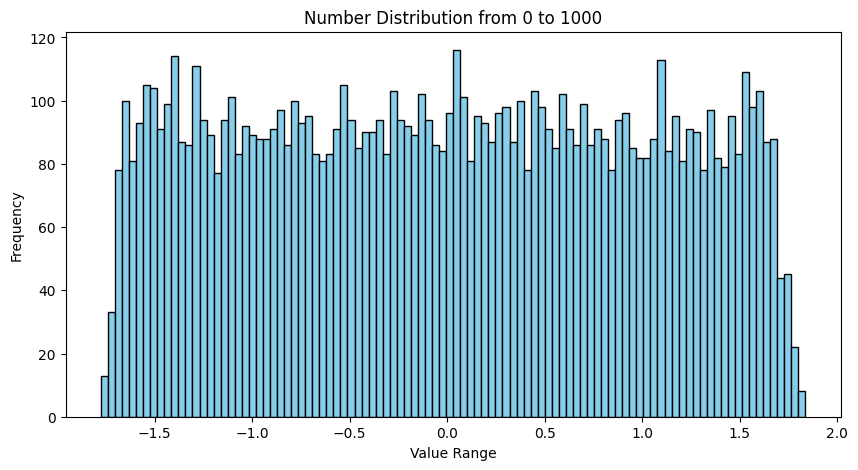

In [6]:

#x_train = x_train.reshape(-1, 1)
#x_test = x_test.reshape(-1, 1)

scaler = StandardScaler()  
x_train = scaler.fit_transform(x_train)  
x_test = scaler.transform(x_test)# Create a plot

plt.figure(figsize=(10, 5))

# Histogram visualization to see frequency distribution
plt.hist(x_train.ravel(), bins=100, color='skyblue', edgecolor='black')
plt.title("Number Distribution from 0 to 1000")
plt.xlabel("Value Range")
plt.ylabel("Frequency")

# Show plot
plt.show()

In [7]:
x_train

array([[ 1.4471417 , -1.66290697, -1.15659865, ..., -1.48326513,
        -0.50506418,  1.00304384],
       [-1.16509363, -1.22015275,  0.71672782, ...,  1.15533982,
         1.44395517, -0.86231433],
       [ 1.06770521,  0.64651392, -1.35612151, ..., -1.07508164,
        -0.51850873, -0.65989517],
       ...,
       [ 1.20482369, -1.11400624,  0.8148373 , ..., -1.22189292,
        -1.24990484,  0.49421016],
       [ 0.08306531, -1.65106646,  0.70346254, ..., -0.04785591,
        -1.62256603,  0.27040483],
       [-0.46696525, -0.98687671,  1.64914407, ...,  0.5000153 ,
        -0.42181926,  0.80852047]])

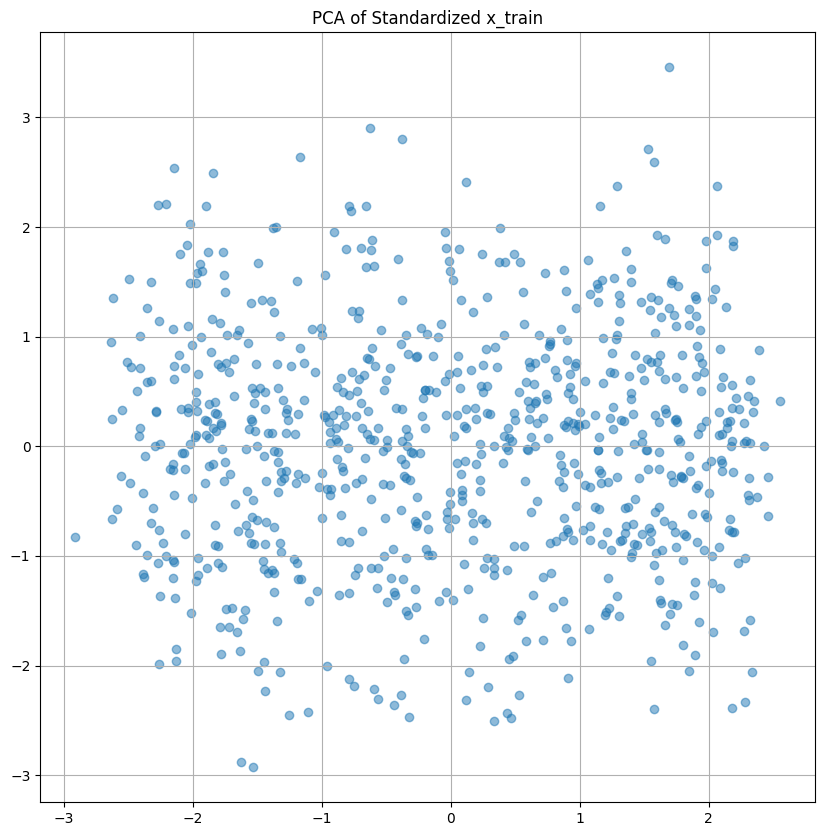

In [8]:
from sklearn.decomposition import PCA

# Reducing to 2 dimensions using PCA
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

# Scatter plot of the 2 principal components
plt.figure(figsize=(10, 10))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], alpha=0.5)
plt.title("PCA of Standardized x_train")
plt.grid(True)
plt.show()


### Datasetin Pytorch'a entegrasyonu
Elimdeki verileri pytorch ile uyumlu hale getiriyorum.

In [9]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to (N,1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape to (N,1)

# Model
### Layers
3 layer; 1 input, 2 hidden layer.
* fc1: Input layer, 11 nöron
* fc2: Hidden layer 1, 16 nöron
* fc3: Hidden layer 2, 8 nöron

### Forward Passing
Output hariç tüm adımları ReLU fonksiyonu ile sağladım. Output olarak 0-1 aralığı lazım olduğu için son fonksiyon sigmoid.  
```Dead neuron var ise leaky ReLU'ya çevirebilirim```

In [10]:

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(11, 180)
        self.bn1 = nn.BatchNorm1d(180)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(180, 180)
        self.bn2 = nn.BatchNorm1d(180)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(180, 1)
        
        # Use LeakyReLU instead of ReLU to prevent dead neurons
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        
    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x

In [11]:
model = SimpleNN()

### Cost Function 
Cost function olarak ***Binary Classification*** yağtığım için **Binary Cross-Entropy** fonksiyonunu kullanacağım.

In [12]:
# Binary Cross-Entropy Cost Function
criterion  = nn.BCELoss()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Dataseti ayırma
Önce labela göre bir ayrım yapıyorum.
x: input, y: output | olacak şekilde
Sonrasonda train ve test olmak üzere 2'ye ayırıyorum. Oranlama olarak %80'e %20 yaptım şimdilik.

In [14]:
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()   # Clear previous gradients
    outputs = model(x_train)  # Forward pass
    
    loss = criterion(outputs, y_train)  # Compute loss
    loss.backward()  # Backpropagation (compute gradients)
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5636
Epoch [20/100], Loss: 0.5001
Epoch [30/100], Loss: 0.4579
Epoch [40/100], Loss: 0.4042
Epoch [50/100], Loss: 0.3595
Epoch [60/100], Loss: 0.3087
Epoch [70/100], Loss: 0.2505
Epoch [80/100], Loss: 0.2203
Epoch [90/100], Loss: 0.2052
Epoch [100/100], Loss: 0.1870


In [20]:
threshold = 0.5
with torch.no_grad():  # Disable gradient computation for evaluation
    y_pred_train = model(x_train)
    rounded_y_pred_train = (y_pred_train > threshold).float()  # Convert probabilities to 0/1 labels
    train_accuracy = (rounded_y_pred_train == y_train).float().mean()
    print(f"Training Accuracy: {train_accuracy.item() * 100:.2f}%")
    
    y_pred_train_np = rounded_y_pred_train.cpu().numpy()
    y_train_np = y_train.cpu().numpy()

    f1_train = f1_score(y_train_np, y_pred_train_np)
    print(f"Train F1-Score: {f1_train:.4f}")
    

    y_pred_test = model(x_test)
    rounded_y_pred_test = (y_pred_test > threshold).float()
    validation_accuracy = (rounded_y_pred_test == y_test).float().mean()
    print(f"Validation Accuracy: {validation_accuracy.item() * 100:.2f}%")
    
    y_pred_test_np = rounded_y_pred_test.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    f1_test = f1_score(y_test_np, y_pred_test_np)
    print(f"Test F1-Score: {f1_test:.4f}")
    
    print("Class 0 count:", (y_pred_test_np == 0).sum())
    print("Class 1 count:", (y_pred_test_np == 1).sum())

Training Accuracy: 92.37%
Train F1-Score: 0.8747
Validation Accuracy: 64.50%
Test F1-Score: 0.3486
Class 0 count: 145
Class 1 count: 55


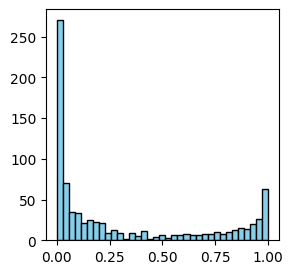

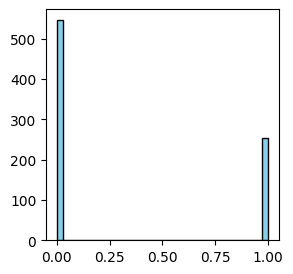

In [16]:
plt.figure(figsize=(3, 3))
plt.hist(y_pred_train, bins=35, color='skyblue', edgecolor='black')
plt.show()

plt.figure(figsize=(3, 3))
plt.hist(y_train, bins=35, color='skyblue', edgecolor='black')
plt.show()

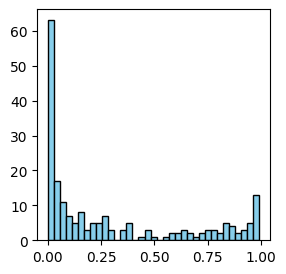

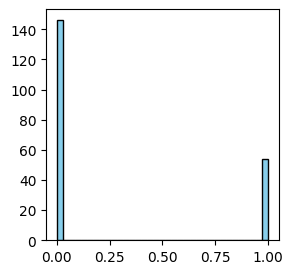

In [17]:
plt.figure(figsize=(3, 3))
plt.hist(y_pred_test, bins=35, color='skyblue', edgecolor='black')
plt.show()

plt.figure(figsize=(3, 3))
plt.hist(y_test, bins=35, color='skyblue', edgecolor='black')
plt.show()

In [18]:
for i in range(25):
    print(y_pred_test[i],"--",y_test[i])

tensor([0.2556]) -- tensor([1.])
tensor([0.0039]) -- tensor([0.])
tensor([0.0235]) -- tensor([0.])
tensor([0.0334]) -- tensor([0.])
tensor([0.0477]) -- tensor([0.])
tensor([0.9208]) -- tensor([0.])
tensor([0.0202]) -- tensor([0.])
tensor([0.0406]) -- tensor([1.])
tensor([0.0010]) -- tensor([0.])
tensor([0.0817]) -- tensor([1.])
tensor([0.0041]) -- tensor([0.])
tensor([0.8249]) -- tensor([0.])
tensor([0.3887]) -- tensor([0.])
tensor([0.2064]) -- tensor([0.])
tensor([0.2617]) -- tensor([1.])
tensor([0.8225]) -- tensor([1.])
tensor([0.0253]) -- tensor([0.])
tensor([0.0012]) -- tensor([0.])
tensor([0.8645]) -- tensor([0.])
tensor([0.1495]) -- tensor([0.])
tensor([0.2216]) -- tensor([0.])
tensor([0.0090]) -- tensor([0.])
tensor([0.0772]) -- tensor([0.])
tensor([0.3009]) -- tensor([0.])
tensor([0.9434]) -- tensor([0.])


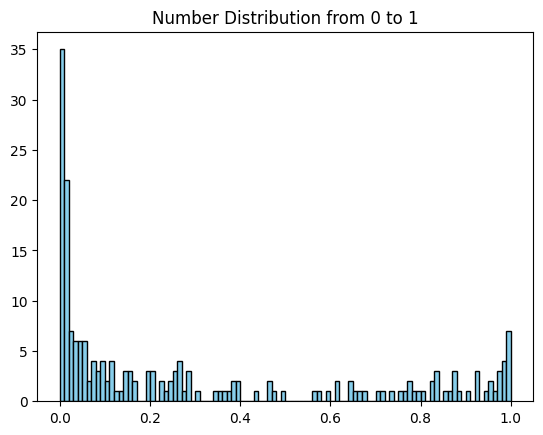

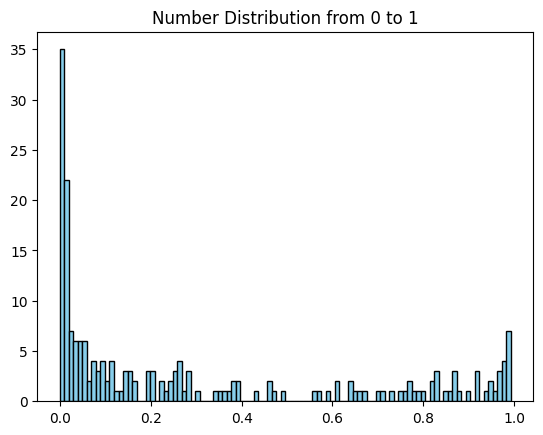

Validation Accuracy: 53.50%


ValueError: Found input variables with inconsistent numbers of samples: [800, 200]

In [19]:
# Apply Min-Max normalization to scale the data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_pred_np = scaler.fit_transform(y_pred_test.cpu().numpy())

plt.hist(normalized_pred_np, bins=100, color='skyblue', edgecolor='black')
plt.title("Number Distribution from 0 to 1")
plt.show()

plt.hist(y_pred_test.cpu().numpy(), bins=100, color='skyblue', edgecolor='black')
plt.title("Number Distribution from 0 to 1")
plt.show()

threshold = 0.3
rounded_normalized_pred_np = (normalized_pred_np >= threshold).astype(int)

normalized_accuracy = (rounded_normalized_pred_np == y_test).float().mean()
print(f"Validation Accuracy: {normalized_accuracy.item() * 100:.2f}%")

f1 = f1_score(y_test_np, rounded_normalized_pred_np)
print(f"F1-Score: {f1:.4f}")
